In [2]:
import torch
from torch.utils.data import DataLoader
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from net import GaussianDiffusion
from net import EpsilonTheta
from sklearn.preprocessing import StandardScaler



In [3]:
num_layers=8
residual_channels=8
dilation_cycle_length=2

In [4]:
def custom_collate_fn(batch):
    """
    Custom collate function to reshape data into [batch size, channels, size].
    """
    # Assuming your signals are originally in the shape [size]
    # and you want to add a single channel dimension
    signals = torch.stack([item['signals'] for item in batch]).unsqueeze(1)  # Adds a channel dimension
    gt = torch.stack([item['gt'] for item in batch])
    sc = torch.stack([item['sc'] for item in batch])
    
    return {'signals': signals, 'gt': gt, 'sc': sc}

In [12]:
file_path = 'datasets/train_set.pth'
dataset = torch.load(file_path)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=None)

In [16]:

epth = EpsilonTheta(target_dim=[256], time_emb_dim=16, residual_layers=8, residual_channels=8, dilation_cycle_length=2, residual_hidden=64)
model=GaussianDiffusion(epth, input_size=[256], beta_end=0.1, diff_steps=100, loss_type="l2", betas=None, beta_schedule="linear")
model_path = './model_checkpoints_1000e/model_epoch_1000.pth'  # Adjust the path and filename as necessary
model.load_state_dict(torch.load(model_path))
model.eval()
all_generated_signals = []


total_signals = 10000
batch_size = 10  

with torch.no_grad():  
    for _ in range(total_signals // batch_size):
        noise_shape = (batch_size, 1, 256) 
        random_noise = torch.randn(noise_shape, device=model.betas.device)
        generated_signals_batch = model.p_sample_loop(random_noise)
        
        # Convert generated signals to CPU and detach from the computation graph
        generated_signals_batch = generated_signals_batch.cpu().detach()
        
        # Append the generated batch to the list
        all_generated_signals.append(generated_signals_batch.numpy())  # Convert to numpy for easier handling

# Concatenate all batches to form a single dataset
generated_signals_dataset = np.concatenate(all_generated_signals, axis=0)


In [17]:
original_signals = []

# Iterate through your DataLoader
for i, data in enumerate(train_loader):
    signals = data['signals']  # Assuming signals shape [batch_size, 1, signal_length]
    for signal in signals:
        # Flatten the signal and convert to numpy array
        flattened_signal = signal.squeeze().cpu().numpy()
        original_signals.append(flattened_signal)

# Convert list of numpy arrays to a single numpy array
original_signals_dataset = np.stack(original_signals)

In [18]:
generated_signals_flattened = generated_signals_dataset.reshape(generated_signals_dataset.shape[0], -1)
combined_dataset = np.concatenate([original_signals_dataset, generated_signals_flattened], axis=0)

# Standardization
scaler = StandardScaler()
combined_dataset_standardized = scaler.fit_transform(combined_dataset)

# Apply PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
pca_result = pca.fit_transform(combined_dataset_standardized)

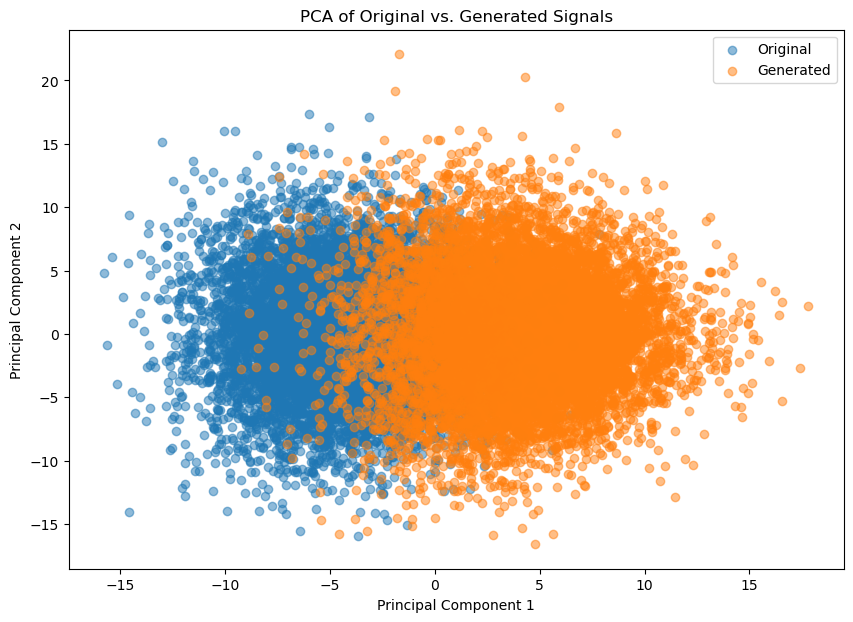

In [22]:
plt.figure(figsize=(10, 7))
plt.scatter(pca_result[:len(original_signals_dataset), 0], pca_result[:len(original_signals_dataset), 1], label='Original', alpha=0.5)
plt.scatter(pca_result[len(original_signals_dataset):, 0], pca_result[len(original_signals_dataset):, 1], label='Generated', alpha=0.5)
plt.legend()
plt.title('PCA of Original vs. Generated Signals')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()